# knn approach to finding traces with flipped polarity in seismic data

We use ML to classify the polarity $(\pm 1)$ of seismic traces. Each trace corresponds to a hydrophone which listens for sound wave reflecting from the geology in the subsurface of the Earth. The sound waves have "shots" as their sources. These shots are denotations set off above the ground.

Sometimes the channel arrays have geophones which are recording data with a phase inversion of -1. That is, they record -f(t) when they should be recording f(t). To process seismic data into a tomographic image, these flipped polarity traces need to be identified.

This open source seismic data comes with channels that have this error. We use a nearest-neighbors algorithm to catalog them.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [2]:
raw_data = pd.read_csv('seismic_traces.txt',header=None,skiprows=[0])

The data is being read as series:

In [3]:
raw_data.shape

(5391360, 1)

But each datapoint is made up of 51 attributes and a target label $(\pm 1)$, so we need to reorganize:

In [4]:
raw_data.head(5)

,0
0,channel=1 shot=2372 label=-1
1,0 1.35109469e-01
2,1 -1.49369106e-01
3,2 1.57715330e+01
4,3 1.42361059e+01


In [5]:
def series_to_dataframe(series,length,sample):
    #function to convert series to dataframe such that entries
    #within [sample_i,sample_(i+52), i % sample = 0, are mapped to a column
    #length = total entries from series to be mapped to the dataframe
    
    df = pd.DataFrame(index=range(0,sample+1))

    for x in range(0,int(length),sample): #for production len(df), or len(df)/2
        df[x] = pd.Series(series.iloc[x:x+53,0].reset_index()[0])
       
    return df

In [6]:
traces_df = series_to_dataframe(raw_data, len(raw_data)/2, 52)

traces_df.head()

,0,52,104,156,208,260,312,364,416,468,...,2695160,2695212,2695264,2695316,2695368,2695420,2695472,2695524,2695576,2695628
0,channel=1 shot=2372 label=-1,channel=9 shot=2372 label=1,channel=17 shot=2372 label=1,channel=25 shot=2372 label=1,channel=33 shot=2372 label=1,channel=41 shot=2372 label=-1,channel=49 shot=2372 label=1,channel=57 shot=2372 label=1,channel=65 shot=2372 label=1,channel=73 shot=2372 label=1,...,channel=2225 shot=6668 label=1,channel=2233 shot=6668 label=1,channel=2241 shot=6668 label=-1,channel=2249 shot=6668 label=1,channel=2257 shot=6668 label=1,channel=2265 shot=6668 label=1,channel=2273 shot=6668 label=1,channel=2281 shot=6668 label=-1,channel=2289 shot=6668 label=1,channel=2297 shot=6668 label=1
1,0 1.35109469e-01,0 1.45933300e-01,0 -6.92833722e-01,0 -5.48514366e-01,0 -5.12570068e-02,0 -8.86980057e-01,0 -1.76063627e-01,0 2.22643271e-01,0 1.17118979e+00,0 5.71239889e-01,...,0 -5.05644798e+01,0 -5.35335121e+01,0 5.16573334e+01,0 -6.36245384e+01,0 -6.22858963e+01,0 -6.69708176e+01,0 -6.17421837e+01,0 4.24557686e+01,0 -3.49117241e+01,0 -3.27148094e+01
2,1 -1.49369106e-01,1 1.75313914e+00,1 1.99631679e+00,1 3.04945016e+00,1 2.88342237e+00,1 -1.33383894e+00,1 1.71477425e+00,1 1.66236949e+00,1 2.14069176e+00,1 1.45541644e+00,...,1 -2.43941898e+01,1 -2.50681992e+01,1 1.98644161e+01,1 -2.24622288e+01,1 -1.41626024e+01,1 -1.40747652e+01,1 -7.30249357e+00,1 1.30712271e+01,1 -8.87607956e+00,1 -1.96998653e+01
3,2 1.57715330e+01,2 -1.49585085e+01,2 -2.35901699e+01,2 -2.49880772e+01,2 -3.32448540e+01,2 2.98935757e+01,2 -3.22538071e+01,2 -2.51346836e+01,2 -1.51347399e+01,2 -5.07944202e+00,...,2 -2.13396549e+01,2 -1.86809387e+01,2 2.29194832e+01,2 -1.65655098e+01,2 -2.28135605e+01,2 -2.79594479e+01,2 -2.25943642e+01,2 3.03915577e+01,2 -2.37743130e+01,2 -2.82103367e+01
4,3 1.42361059e+01,3 -1.81383457e+01,3 -1.35441465e+01,3 -7.66792870e+00,3 -1.11441040e+01,3 1.45502367e+01,3 -1.61157742e+01,3 -1.30265388e+01,3 -2.11821022e+01,3 -3.24019890e+01,...,3 -1.31772375e+01,3 -7.91394949e+00,3 2.81915817e+01,3 -2.24558468e+01,3 -3.33276749e+01,3 -3.37345467e+01,3 -2.52948914e+01,3 2.34377728e+01,3 -1.42750978e+01,3 -7.85312891e+00


In [7]:
def select_amplitude(x):
    #function to select the amplitude value from each cell:
    # '2 -2.35901699e+01'  ---> '-2.35901699e+01'
    
    ls = x.split()
    return ls[len(ls)-1]

def pickSign(str):      
    # function to pick send 'gut=-1' ---> -1, 'gut=1' ---> 1
    
    if str[-2:-1]=='-':
        return -1
    else:
        return 1

In [11]:
#Select amplitude value from each cell. 
#Transpose so that the samples of the traces become attributes
data_df = traces_df.applymap(select_amplitude).transpose()

#Create integer target label
data_df['Polarity']= data_df[0].apply(pickSign)
data_df = data_df.drop(labels=[0,52],axis=1)

**Now we have the data in the shape that we want. Every row corresponds to a data point, with the entries being the samples of the recorded sound waves. The last column contains the polarity label.**

In [12]:
data_df.head()

,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,Polarity
0,1.35109469e-01,-1.49369106e-01,1.57715330e+01,1.42361059e+01,-3.59257355e+01,2.69094620e+01,-1.50129881e+01,1.72546041e+00,7.09569931e+00,1.46335602e+00,...,3.21032262e+00,-6.10652637e+00,-6.63434744e+00,7.87241983e+00,6.82086897e+00,-4.39545631e+00,7.42289352e+00,1.75441399e+01,3.22355962e+00,-1
52,1.45933300e-01,1.75313914e+00,-1.49585085e+01,-1.81383457e+01,2.48362637e+01,-1.77127659e+00,6.10797930e+00,6.50432706e-01,1.24292898e+01,-2.07663879e+01,...,-6.89559555e+00,-2.26281190e+00,8.67931843e-01,6.58300161e+00,-2.52325439e+00,1.95214581e+00,-1.05873799e+00,6.87787950e-01,5.56250906e+00,1
104,-6.92833722e-01,1.99631679e+00,-2.35901699e+01,-1.35441465e+01,1.63886700e+01,-2.81123400e+00,2.92025834e-01,1.99671593e+01,1.88208694e+01,-1.40622349e+01,...,5.06641245e+00,-4.83957577e+00,-7.73365974e+00,3.41644979e+00,-2.48874712e+00,-6.23853803e-01,-5.78418303e+00,-1.94017529e+00,3.14864397e+00,1
156,-5.48514366e-01,3.04945016e+00,-2.49880772e+01,-7.66792870e+00,1.78881626e+01,-1.10457926e+01,9.76121712e+00,1.14444103e+01,4.48660088e+00,-8.39676380e+00,...,8.91458607e+00,4.63351870e+00,-4.62167472e-01,-4.35263920e+00,-6.80716562e+00,4.04786921e+00,5.90873194e+00,-9.53969765e+00,-5.92452812e+00,1
208,-5.12570068e-02,2.88342237e+00,-3.32448540e+01,-1.11441040e+01,1.66472816e+01,-1.51332645e+01,2.12284908e+01,4.14150047e+00,1.19304018e+01,-1.90980256e+00,...,5.17904234e+00,-3.36299109e+00,6.31671906e+00,8.00372982e+00,-8.22849369e+00,-1.98929179e+00,1.32404604e+01,7.56298685e+00,-2.87491727e+00,1


In [13]:
data_df.shape

(51840, 52)

In [25]:
# To write out the above dataframe to have it stored after the flow of modifications, use:
# df4.to_csv('parallel_traces.csv',index=False)

## Resampling the data

We note that the data is umbalanced. There are about ~4x as many taces with positive polarity than negative. So we we address this issue by resampling the number of negative-polarity traces by upsampling this category.

In [23]:
from sklearn.utils import resample

In [24]:
print('Number of seismic traces with positive polarity =', len(data_df[data_df.Polarity == 1]))
print('Number of seismic traces with negative polarity =', len(data_df[data_df.Polarity == -1]))

Number of seismic traces with positive polarity = 41400
Number of seismic traces with negative polarity = 10440


In [27]:
# We upsample the minority class by creating random copies of the 
# samples in this class.

new_negative_batch = resample(data_df[data_df.Polarity == -1], n_samples = 31000, random_state=0)
balanced_data = pd.concat([data_df,new_negative_batch])


print('\n~~~~~~~~~~ After upsampling:\n ')
print('Number of seismic traces with positive polarity =', len(balanced_data[balanced_data.Polarity == 1]))
print('Number of seismic traces with negative polarity =', len(balanced_data[balanced_data.Polarity == -1]))


~~~~~~~~~~ After upsampling:
 
Number of seismic traces with positive polarity = 41400
Number of seismic traces with negative polarity = 41440


## Building the nearest-neighbors model
We proceed to split the data for training/testing and build the model. We also split a validation set.

In [28]:
X = balanced_data.drop(labels='Polarity',axis=1)
y = balanced_data['Polarity']*-1
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

We test to find the optimal k, the number of neighbors, via cross validation using cross_val_score. Since this is a classification problem, we test for accuracy.

In [29]:
cv_scores = []
for n in range(1,14,2):
    knn = KNeighborsClassifier(n_neighbors=n,weights='uniform')
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())


 Accuracies are  [0.976195074843071, 0.9485433767906004, 0.9281184612908419, 0.9155480444229841, 0.9033639143730886, 0.8947529373893449, 0.8874778689843875]

 Optimal k = 1


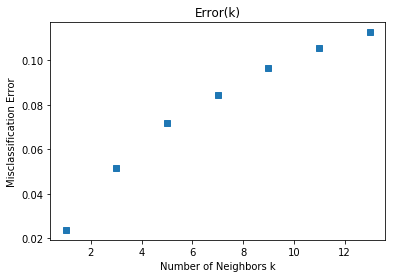

In [36]:
# Let's plot the misclassification error, call it msc
msc = [1 - x for x in cv_scores]
print('\n Accuracies are ', cv_scores)

n_vals = (list(range(1,14,2)))
optimalMSC = n_vals[msc.index(min(msc))]
print('\n Optimal k =', optimalMSC)

plt.plot(n_vals, msc,'s')

plt.title('Error(k)')
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.show()



In [37]:
knn1 = KNeighborsClassifier(n_neighbors=1, weights='uniform').fit(X_train,y_train)
print('Score for k = 1 knn-model', knn1.score(X_test,y_test))

Score for k = 1 knn-model 0.9913568324480927


In [38]:
y_test_reset = y_test.reset_index()
print(y_test_reset.iloc[60:80])

      index  Polarity
60   602108        -1
61  1890616         1
62  1670396         1
63   813124         1
64  2659072         1
65  1086020        -1
66   463840         1
67  1941212        -1
68  2680964         1
69  1480388         1
70    69264         1
71   685984        -1
72  1065948        -1
73  2548364        -1
74   559832         1
75  2207192         1
76  1502280         1
77  1115244         1
78  1494948        -1
79  2401204        -1


### Can we improve the model via some l2-scaling in preprocessing?

Answer: yes, but minimally so.

In [23]:
transformer = Normalizer(norm='l2').fit(X_train)  
X_train_scaled = transformer.transform(X_train)
X_test_scaled = transformer.transform(X_test)

In [25]:
nrnb1_scaled  = KNeighborsClassifier(n_neighbors=1, weights='uniform').fit(X_train_scaled,y_train)
print('Using l2-normalization on each observation gives an accuracy of the k = 1 model of', nrnb1_scaled.score(X_test_scaled,y_test))

Using l2-normalization on each observation gives an accuracy of the k = 1 model of 0.9543209876543209


### Can we use only two attributes?

The answer is, it depends. For example, we will see that if we use X[[10,20]] then we don't even beat the most-frequent dummy classfier. Then we will see that if choose X[[1,2]] for our attributes, we get a much improved accuracy but still lag behind the 51-dimensional model. 

In [26]:
X2d_train,X2d_test,y2d_train,y2d_test = train_test_split(X[[10,20]],y,random_state=0)

In [27]:
cv_scores_2d = []
for n in range(3,50,2):
    knn = KNeighborsClassifier(n_neighbors=n,weights='uniform')
    scores = cross_val_score(knn, X2d_train, y2d_train, cv=5, scoring='accuracy')
    cv_scores_2d.append(scores.mean())


 2d case: optimal k = 39


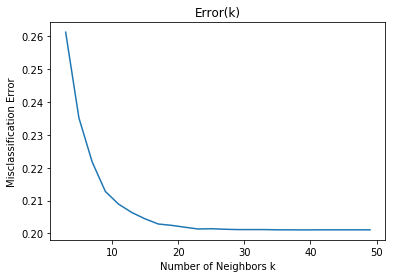

In [29]:
# Let's plot the misclassification error, call it msc
msc_2d = [1 - x for x in cv_scores_2d]

n_vals_2d = (list(range(3,50,2)))
optimalMSC_2d = n_vals_2d[msc_2d.index(min(msc_2d))]
print('\n 2d case: optimal k =', optimalMSC_2d)

plt.plot(n_vals_2d, msc_2d)

plt.title('Error(k)')
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.show()

In [31]:
#Seems ok to stop at k = 30:
nrnb_2d = KNeighborsClassifier(n_neighbors=39, weights='uniform').fit(X2d_train,y2d_train)

In [32]:
print('Using the X[[10,20]] and knn with k=39 we obtain an accuracy of ',  nrnb_2d.score(X2d_test,y2d_test))

Using the X[[10,20]] and knn with k=39 we obtain an accuracy of  0.7977623456790124


How does it compare to the dummy classifier?

In [33]:
from sklearn.dummy import DummyClassifier

mostFreq_clsf = DummyClassifier(strategy='most_frequent').fit(X2d_train,y2d_train)
uniform_clsf = DummyClassifier(strategy='uniform').fit(X2d_train,y2d_train)

In [34]:
print('Dummy most-frequent classifier has accuracy =', mostFreq_clsf.score(X2d_test,y2d_test))
print('Dummy uniform classifier has accuracy =', uniform_clsf.score(X2d_test,y2d_test))

Dummy most-frequent classifier has accuracy = 0.7977623456790124
Dummy uniform classifier has accuracy = 0.49421296296296297


__Using the two attributes X[[10,20]] does not seem to be useful since we do not beat the most-frequent classifier.__

How about if we try using the first two attributes as opposed to the 10,20 ones?

In [35]:
X2d_train_2,X2d_test_2,y2d_train_2,y2d_test_2 = train_test_split(X[[1,2]],y,random_state=0)
nrnb_2d_firstAttributes = KNeighborsClassifier(n_neighbors=39,weights='uniform').fit(X2d_train_2,y2d_train_2)

In [36]:
print('Using the first two attributes X[[1,2]] gives accuracy of', nrnb_2d_firstAttributes.score(X2d_test_2,y2d_test_2))

Using the first two attributes X[[1,2]] gives accuracy of 0.8258487654320987


__Using the two first two attributes with k = 39 gives an accuracy of 0.83 which is quite good given than we are using only two attributes vs. the the 51 attributes we have for each observation.__

Below we test whether a different k value is more appropriate when using X[[1,2]].

In [37]:
cv_scores_2d_2 = []
for n in range(10,150,10):
    knn = KNeighborsClassifier(n_neighbors=n, weights='uniform')
    score = cross_val_score(knn,X2d_train_2,y2d_train_2,cv=3,scoring='accuracy')
    cv_scores_2d_2.append(score.mean())


 2d case: optimal k = 120


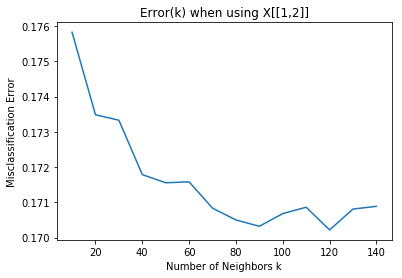

In [38]:
# Get the misclassification error:
msc_firstAttributes = [1-x for x in cv_scores_2d_2]
n_vals_2d = (list(range(10,150,10)))

optimalMSC_2d_2 = n_vals_2d[msc_firstAttributes.index(min(msc_firstAttributes))]

print('\n 2d case: optimal k =', optimalMSC_2d_2)

plt.figure()
plt.plot(n_vals_2d,msc_firstAttributes)
plt.title('Error(k) when using X[[1,2]]')
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.show()

Although k = 120 is optimal, from the plot above we see the error is not too different from using smaller value.

### Let's plot the 2d model

We will use the model based on the first two attributes.

In [39]:
print(X2d_train_2.head())

                       1                2
439660   -1.03471923e+00  -5.97857475e-01
1914016   2.51424591e+02   1.54621094e+02
420420    1.45749524e-01  -2.43782178e-01
309868    1.59413166e+01   3.41016121e+01
1598064  -1.05631836e+02   1.04834702e+02


In [40]:
x1_min, x1_max = X2d_train_2[1].astype('float').min() - 1, X2d_train_2[1].astype('float').max() + 1
x2_min, x2_max = X2d_train_2[2].astype('float').min() - 1, X2d_train_2[2].astype('float').max() + 1

In [41]:
h = 1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                         np.arange(x2_min, x2_max, h))

In [42]:
Z = nrnb_2d_firstAttributes.predict(np.c_[xx.ravel(), yy.ravel()])

In [43]:
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

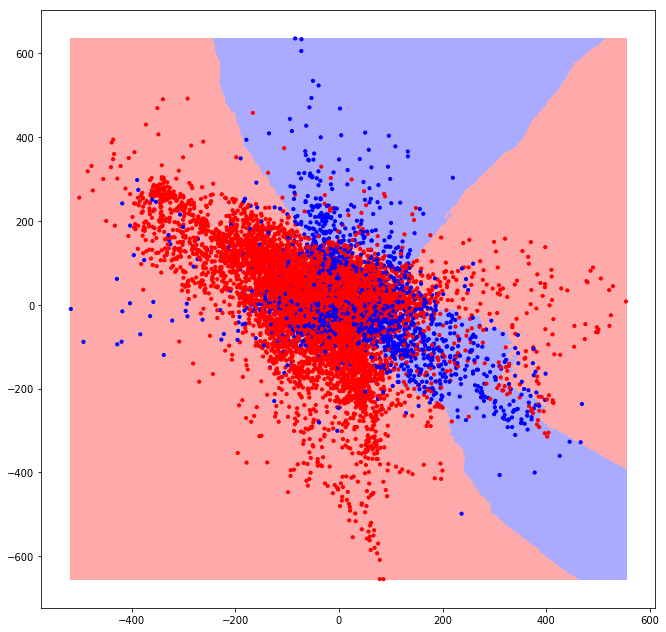

In [44]:
Z = Z.reshape(xx.shape)
plt.figure(figsize=(11,11))
plt.pcolormesh(xx, yy, Z,cmap=cmap_light)

# plotting the training data points
plt.scatter(X2d_train_2[1].astype('float'),X2d_train_2[2].astype('float'),c=y2d_train_2,s=10,cmap=cmap_bold)
plt.show()


In our cross validation step we saw that k ~ neighbors is optimal according the accuracy measure when we working with the X[1],X[2] 2d-model. For comparison, let's generate the above map when using the lower k = 10

In [45]:
nrnb_2d_firstAttributes_k5 = KNeighborsClassifier(n_neighbors=5,weights='uniform').fit(X2d_train_2,y2d_train_2)

In [46]:
Z_k5 = nrnb_2d_firstAttributes_k5.predict(np.c_[xx.ravel(), yy.ravel()])

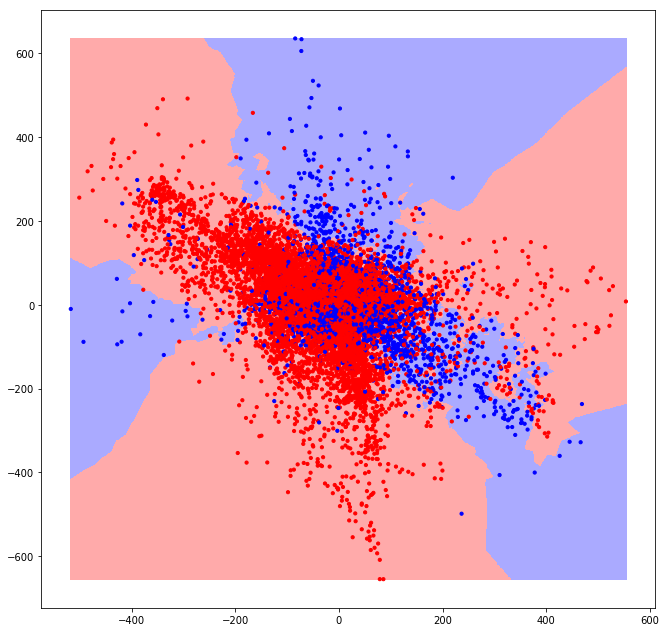

In [47]:
Z_k5 =Z_k5.reshape(xx.shape)

plt.figure(figsize=(11,11))
plt.pcolormesh(xx,yy,Z_k5,cmap=cmap_light)
plt.scatter(X2d_train_2[1].astype('float'),X2d_train_2[2].astype('float'),c=y2d_train_2,s=10,cmap=cmap_bold)
plt.show()

### Can we improve our results if we normalize the input data?

We will see if that in the 2d-dimensional case l2-normalization of each trace is not helpful (actually harmful).

In [48]:
from sklearn.preprocessing import Normalizer

In [49]:
transformer = Normalizer(norm='l2').fit(X2d_train_2)
X2d_train_scaled = transformer.transform(X2d_train_2)
X2d_test_scaled = transformer.transform(X2d_test_2)

In [50]:
X2d_train_2.head()

,1,2
439660,-1.03471923e+00,-5.97857475e-01
1914016,2.51424591e+02,1.54621094e+02
420420,1.45749524e-01,-2.43782178e-01
309868,1.59413166e+01,3.41016121e+01
1598064,-1.05631836e+02,1.04834702e+02


In [51]:
X2d_train_scaled

array([[-0.86585793, -0.50028996],
       [ 0.85181212,  0.52384741],
       [ 0.51314951, -0.85829924],
       ...,
       [-0.84555938, -0.53388139],
       [ 0.16935147,  0.98555572],
       [-0.53483076, -0.8449592 ]])

In [52]:
nrnb_scaled = KNeighborsClassifier(n_neighbors=30,weights='uniform').fit(X2d_train_scaled,y2d_train_2)

In [54]:
print('After ls-normalizing each observation, we obtain an accuracy of', nrnb_scaled.score(X2d_test_scaled,y2d_test_2))

After ls-normalizing each observation, we obtain an accuracy of 0.7949845679012346


Normalizing isn't helpful for this dataset.